In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import pandas as pd
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/post-data-x1/Pst data - Copy of Set of work 2 - Sheet1.csv.csv


### **Data Extraction & Cleaning**

In [58]:
reddit_data = pd.read_csv('/kaggle/input/post-data-x1/Pst data - Copy of Set of work 2 - Sheet1.csv.csv')
reddit_data.head(5)

,clean_post,category
0,My brother in-law (Sammy) lost his home shortl...,-1.0
1,Iâve enjoyed reading and posting on this sub...,0.0
2,"I'm back like I said I would be,. My [original...",-1.0
3,I'll try to keep this short. I had a [1967 Imp...,-1.0
4,I want to sincerely thank everyone who comment...,-1.0


In [59]:
def clean_post(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    clean_comment = ' '.join(''.join([i for i in string if not i.isdigit()]).split())
    
    for i in punc:
        clean_comment = clean_comment.replace(i, '')
        
    a = [i for i in clean_comment if i.isalpha() or i == ' ']
            
    final_text = ' '.join(''.join(a).split())
    return final_text

***Cleaning Data***

In [60]:
reddit_data = reddit_data.dropna(how='any')


In [61]:
reddit_data.rename(columns={'clean_post':'clean_post'}, inplace=True)

reddit_data.category = reddit_data.category.apply(lambda x: int(x))

reddit_data.clean_post = reddit_data.clean_post.apply(clean_post)

In [62]:
reddit_data.drop_duplicates(subset='clean_post', keep=False, inplace=True)


In [63]:
# Concat reddit data 
concat_df = pd.concat([reddit_data], ignore_index=True)
concat_df.drop_duplicates(subset='clean_post', keep=False, inplace=True)

### **Data Visualization**

***Compare Total post
From both Platforms***

In [64]:
counts = [len(reddit_data), len(concat_df)]
labels = ['Reddit',  'Total']
colors = ['#ff4500',  '#50C878']

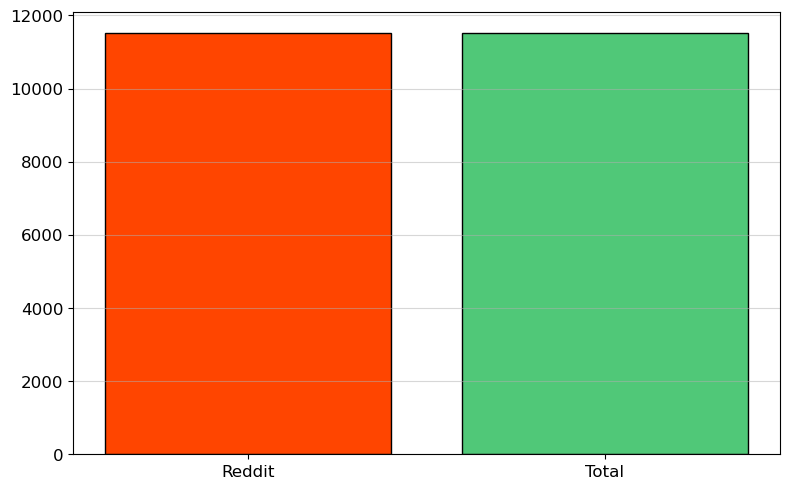

In [65]:
plt.figure(figsize=(8,5))

plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

***Count The Negative, Neutral, and Positive post***

In [66]:
negative_count = [len(reddit_data[reddit_data.category == -1]),
                 len(concat_df[concat_df.category == -1])]

neutral_count = [len(reddit_data[reddit_data.category == 0]),
                 len(concat_df[concat_df.category == 0])]

positive_count = [len(reddit_data[reddit_data.category == 1]),
                 len(concat_df[concat_df.category == 1])]

x = ['Reddit', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

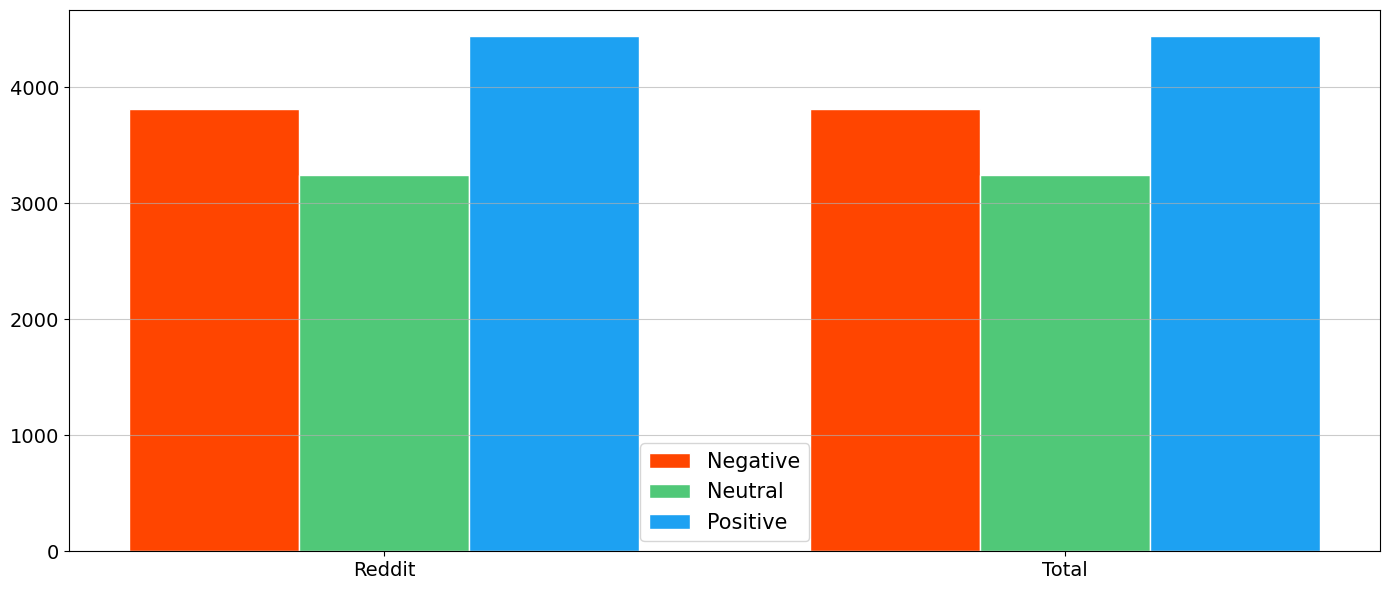

In [67]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

***Count the Average Length of All the 3 Sentiments Comment***

In [68]:
negative_avg = int(sum([len(i) for i in concat_df[concat_df.category == -1].clean_post]) / len(concat_df[concat_df.category == -1]))
neutral_avg = int(sum([len(i) for i in concat_df[concat_df.category == 0].clean_post]) / len(concat_df[concat_df.category == 0]))
positive_avg = int(sum([len(i) for i in concat_df[concat_df.category == 1].clean_post]) / len(concat_df[concat_df.category == 1]))

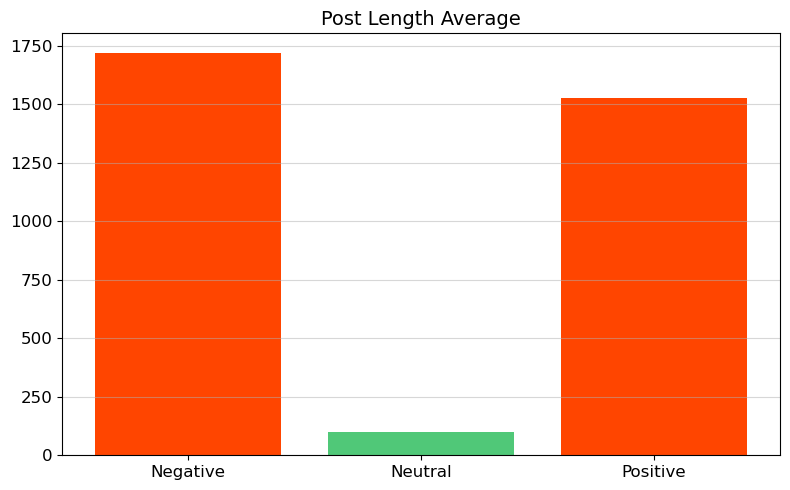

In [69]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg], color=colors)

plt.title('Post Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

***Create Word Clouds to See Which Words Appear Frequently***

In [70]:
negative_words = ''
neutral_words = ''
positive_words = ''

stopwords = set(STOPWORDS)

for comment, category in zip(concat_df.clean_post, concat_df.category):
    tokens = comment.split()
    
    for word in tokens:
        if category == -1:
            negative_words += word + ' '
        elif category == 0:
            neutral_words += word + ' '
        else:
            positive_words += word + ' '

In [71]:
negative_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 20).generate(negative_words)

neutral_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 20).generate(neutral_words)

positive_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 20).generate(positive_words)

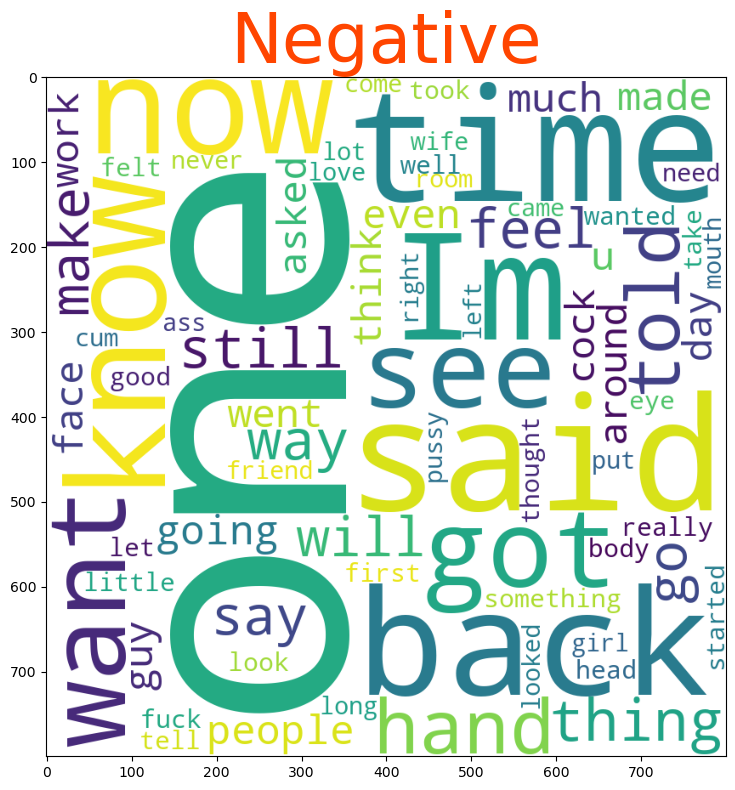

In [72]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(25, 8), facecolor=None)

ax1.imshow(negative_cloud)
ax1.set_title('Negative', fontsize=50, color='#ff4500')


plt.tight_layout()

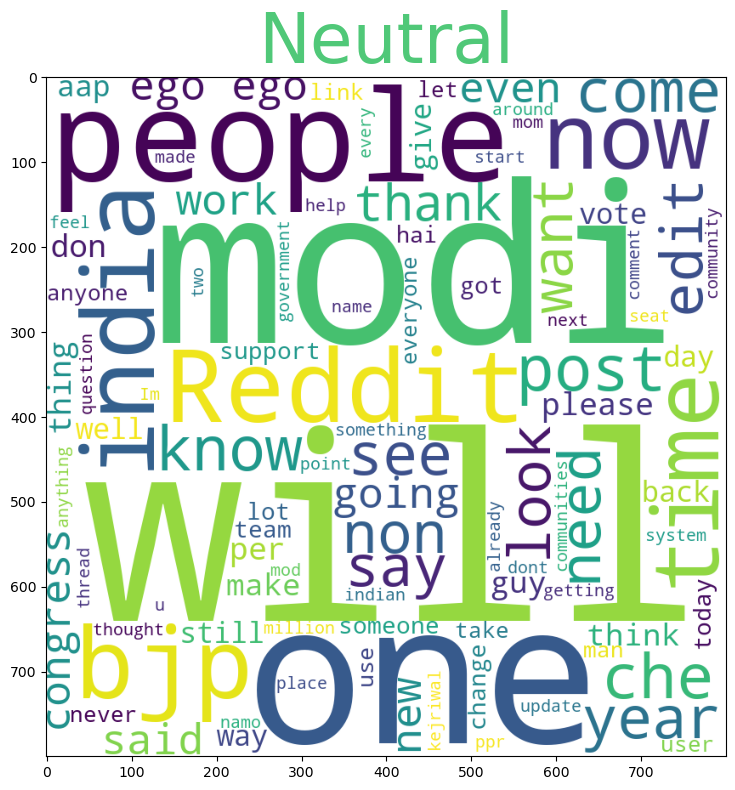

In [73]:
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(25, 8), facecolor=None)

ax2.imshow(neutral_cloud)
ax2.set_title('Neutral', fontsize=50, color='#50C878')

plt.tight_layout()

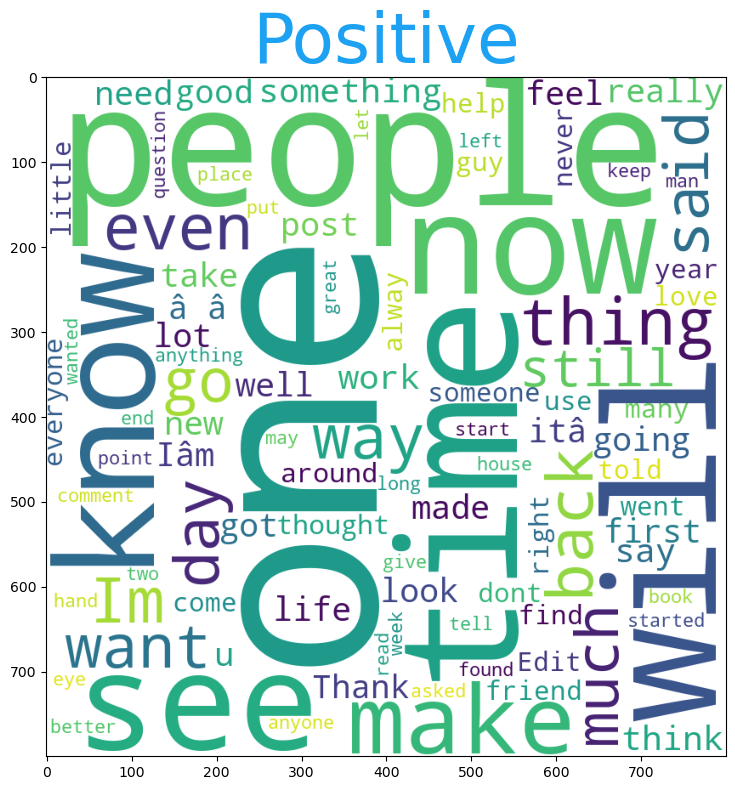

In [74]:
fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(25, 8), facecolor=None)

ax3.imshow(positive_cloud)
ax3.set_title('Positive', fontsize=50, color='#1DA1F2')

plt.tight_layout()

### **Split Test & Train Data**

***Balance the Data (The Amount of Negative, Neutral, and Positive Data Must be Equivalent)***

In [75]:
class Data:
    def __init__(self, df):
        self.df = df
        
    def fixData(self):
        dataframe = self.df
        lowest_len = min([i for i in dataframe.category.value_counts()])
        
        # Create the final data frame
        final_df = pd.concat([dataframe[dataframe.category == -1][:lowest_len],
                             dataframe[dataframe.category == 0][:lowest_len],
                             dataframe[dataframe.category == 1][:lowest_len]])
        
        # To shuffle the rows in the data frame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        return final_df

***Split Train and Test Data***

In [76]:
a = Data(concat_df)
fixed_df = a.fixData()
print(f'Before: \n{concat_df.category.value_counts()}\n')
print(f'After: \n{fixed_df.category.value_counts()}')

Before: 
 1    4444
-1    3817
 0    3244
Name: category, dtype: int64

After: 
 1    3244
-1    3244
 0    3244
Name: category, dtype: int64


In [77]:
train_X, test_X, train_y, test_y = train_test_split([i for i in fixed_df.clean_post], [i for i in fixed_df.category], test_size=0.25, random_state=1)

***Vectorize the Comment***

In [78]:
vectorizer = TfidfVectorizer()
train_X_vectors = vectorizer.fit_transform(train_X)
test_X_vectors = vectorizer.transform(test_X)

### **Creating Models**

***Linear SVC***

In [79]:
clf_svm = LinearSVC()
clf_svm.fit(train_X_vectors, train_y)
clf_prediction = clf_svm.predict(test_X_vectors)



print(f'Accuracy: {clf_svm.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, clf_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.8146321413892315
Accuracy: [0.75862069 0.87345497 0.80788804]


In [80]:
cr = classification_report(test_y, clf_prediction)
print(cr)

              precision    recall  f1-score   support

          -1       0.80      0.72      0.76       835
           0       0.82      0.94      0.87       792
           1       0.83      0.79      0.81       806

    accuracy                           0.81      2433
   macro avg       0.81      0.82      0.81      2433
weighted avg       0.81      0.81      0.81      2433



***MultinomialNB***

In [81]:
svm_mnb = MultinomialNB()
svm_mnb.fit(train_X_vectors, train_y)
mnb_prediction = svm_mnb.predict(test_X_vectors)

print(f'Accuracy: {svm_mnb.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, mnb_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.675297986025483
Accuracy: [0.69484029 0.62876254 0.68501529]


In [82]:
cr = classification_report(test_y, mnb_prediction)
print(cr)

              precision    recall  f1-score   support

          -1       0.59      0.85      0.69       835
           0       0.93      0.47      0.63       792
           1       0.68      0.69      0.69       806

    accuracy                           0.68      2433
   macro avg       0.73      0.67      0.67      2433
weighted avg       0.73      0.68      0.67      2433



***Decision Tree Classifier***

In [83]:
svm_dtc = DecisionTreeClassifier()
svm_dtc.fit(train_X_vectors, train_y)
dtc_prediction = svm_dtc.predict(test_X_vectors)

print(f'Accuracy: {svm_dtc.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, dtc_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.6913275791204274
Accuracy: [0.64669927 0.79549967 0.64223386]


In [84]:
cr = classification_report(test_y, dtc_prediction)
print(cr)

              precision    recall  f1-score   support

          -1       0.66      0.63      0.65       835
           0       0.84      0.76      0.80       792
           1       0.60      0.68      0.64       806

    accuracy                           0.69      2433
   macro avg       0.70      0.69      0.69      2433
weighted avg       0.70      0.69      0.69      2433

